# The code is written for the purpose of (x,y) pole coordinates prediction, using LSTM neural networks
# There are five tests, namely x alone, y alone, x and y for x, x and y for y, and x and y for x and y

# By Mostafa Kiani Shahvandi, Bendedikt Soja. Space Geodesy Group, ETH Zurich [space.igp.ethz.ch](https://space.igp.ethz.ch)

# Packages loading- common among all

In [1]:
import os
import datetime
from datetime import timedelta
import IPython
import calendar
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import glob
import tensorflow.keras.backend as K
mpl.rcParams['figure.figsize'] = (14, 8)
mpl.rcParams['axes.grid'] = False
import random
from pyts.decomposition import SingularSpectrumAnalysis
from numpy import array
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout, RepeatVector, TimeDistributed
from numpy import hstack
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Useful function for converting the fractional year to the year-month-day-hour-min-sec 

In [2]:
def convert_partial_year(number):

    year = int(number)
    d = timedelta(days=(number - year)*(365 + calendar.isleap(year)))
    day_one = datetime.datetime(year,1,1)
    date = d + day_one
    return date

# Data loading-common among all

In [3]:
filelist=[]

for filename in glob.iglob('.//eopc04_14_IAU2000.62-now.txt', recursive=True):
    if os.path.isfile(filename): # filter dirs
        filelist.append(filename)
        df = pd.read_fwf(filename,skiprows=[i for i in range (1,8500)],header=0)
        break
        

df['yyyy.yyyy']=df['year']+df['mo']/12+df['day']/365.25
date_time=df['yyyy.yyyy']

for i in range(df.shape[0]):
     date_time[i]=convert_partial_year(df['yyyy.yyyy'][i]) 


date_time = pd.to_datetime(df.pop('yyyy.yyyy'), format='%d.%m.%Y %H:%M:%S')

df['doy']=1
doy=df['doy']
for i in range(df.shape[0]):
     doy1=pd.Period(date_time[i],freq='D')
     doy[i]=doy1.dayofyear 

<ipython-input-3-e036541d388f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_time[i]=convert_partial_year(df['yyyy.yyyy'][i])
<ipython-input-3-e036541d388f>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doy[i]=doy1.dayofyear


# Data visualization

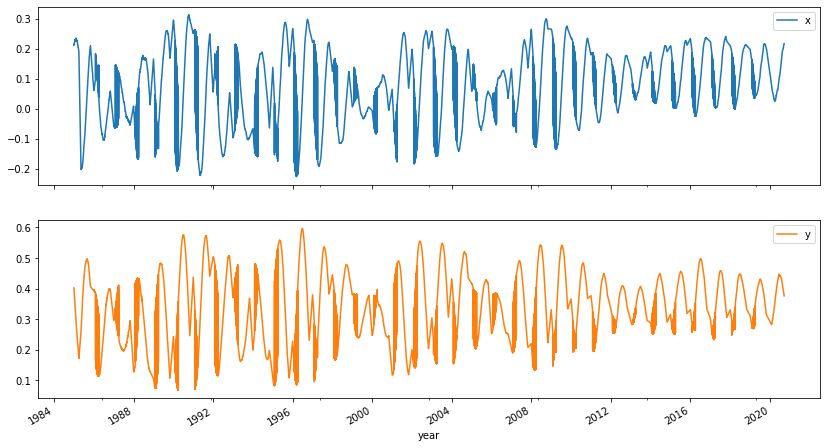

In [4]:
date_time.name='year'
plot_cols = ['x','y']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

# Creating time signal

Text(0.5, 1.0, 'Day of year signal')

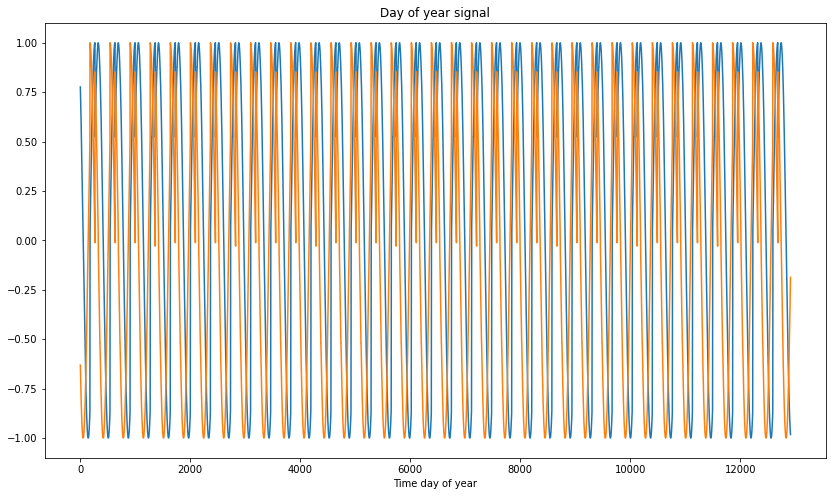

In [5]:
df['Day sin'] = np.sin(df['day'] * (2 * np.pi / 30))
df['Day cos'] = np.cos(df['day'] * (2 * np.pi / 30))
df['Month sin'] = np.sin(df['mo'] * (2 * np.pi / 12))
df['Month cos'] = np.cos(df['mo'] * (2 * np.pi / 12))

df['doy sin']=np.sin(df['doy'] * (2 * np.pi / 365.25))
df['doy cos']=np.cos(df['doy'] * (2 * np.pi / 365.25))

#df['semi Day sin'] = np.sin(timestamp_s * (2 * np.pi / semiDay))
#df['semi Day cos'] = np.cos(timestamp_s * (2 * np.pi / semiDay))

plt.plot(np.array(df['doy sin'])[:])
plt.plot(np.array(df['doy cos'])[:])
plt.xlabel('Time day of year')
plt.title('Day of year signal')

# Creating data for the five tests 

In [6]:
############## Test1: prediction of x based on time and x itself

u=df[['x','doy sin','doy cos']]
df_x=u

n = len(df_x)
train_df_x = df_x[0:int(n*0.8)]

val_df_x = df_x[int(n*0.8):int(n*0.9)]
test_df_x = df_x[int(n*0.9):]
column_indices_x = {name: i for i, name in enumerate(df_x.columns)}
#################################################################

############## Test2: prediction of y based on time and y itself

u=df[['y','doy sin','doy cos']]
df_y=u

n = len(df_y)
train_df_y = df_y[0:int(n*0.8)]

val_df_y = df_y[int(n*0.8):int(n*0.9)]
test_df_y = df_y[int(n*0.9):]
column_indices_y = {name: i for i, name in enumerate(df_y.columns)}
#################################################################

############## Test3-5: prediction of x (y) based on time and x(y) (and y(x))

u=df[['x','y','doy sin','doy cos']]
df_xy=u

n = len(df_xy)
train_df_xy = df_xy[0:int(n*0.8)]

val_df_xy = df_xy[int(n*0.8):int(n*0.9)]
test_df_xy = df_xy[int(n*0.9):]
column_indices_xy = {name: i for i, name in enumerate(df_xy.columns)}
############################################################################

# Data normalization

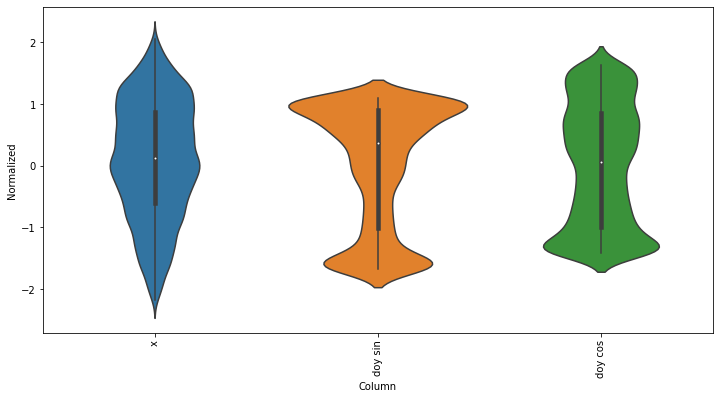

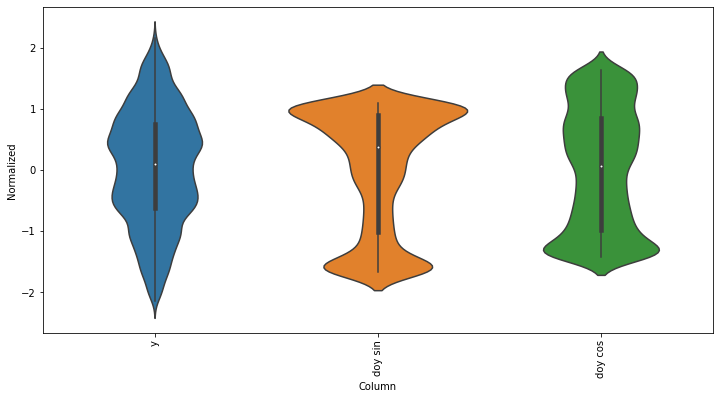

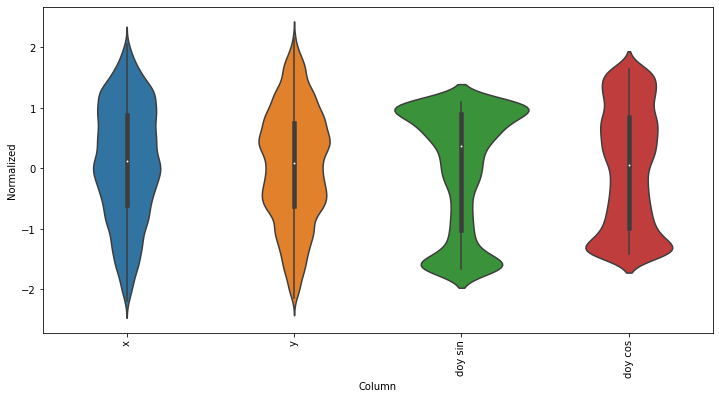

In [7]:
############## Test1: prediction of x based on time and x itself

train_mean_x = train_df_x.mean()
train_std_x = train_df_x.std()
train_df_x = (train_df_x - train_mean_x) / train_std_x
val_df_x = (val_df_x - train_mean_x) / train_std_x
test_df_x = (test_df_x - train_mean_x) / train_std_x

train_df_x=pd.DataFrame.dropna(train_df_x,axis=1)
val_df_x=pd.DataFrame.dropna(val_df_x,axis=1)
test_df_x=pd.DataFrame.dropna(test_df_x,axis=1)

num_features_x = test_df_x.shape[1]

df_std_x = (df_x - train_mean_x) / train_std_x
df_std_x=pd.DataFrame.dropna(df_std_x,axis=1)
df_std_x= df_std_x.melt(var_name='Column', value_name='Normalized')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std_x)
_ = ax.set_xticklabels(test_df_x.keys(), rotation=90)
####################################################################

############## Test2: prediction of y based on time and y itself

train_mean_y = train_df_y.mean()
train_std_y = train_df_y.std()
train_df_y = (train_df_y - train_mean_y) / train_std_y
val_df_y = (val_df_y - train_mean_y) / train_std_y
test_df_y = (test_df_y - train_mean_y) / train_std_y

train_df_y=pd.DataFrame.dropna(train_df_y,axis=1)
val_df_y=pd.DataFrame.dropna(val_df_y,axis=1)
test_df_y=pd.DataFrame.dropna(test_df_y,axis=1)

num_features_y = test_df_y.shape[1]

df_std_y = (df_y - train_mean_y) / train_std_y
df_std_y=pd.DataFrame.dropna(df_std_y,axis=1)
df_std_y= df_std_y.melt(var_name='Column', value_name='Normalized')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std_y)
_ = ax.set_xticklabels(test_df_y.keys(), rotation=90)
####################################################################

############## Test3-5: prediction of x (y) based on time and x(y) (and y(x))

train_mean_xy = train_df_xy.mean()
train_std_xy = train_df_xy.std()
train_df_xy = (train_df_xy - train_mean_xy) / train_std_xy
val_df_xy = (val_df_xy - train_mean_xy) / train_std_xy
test_df_xy = (test_df_xy - train_mean_xy) / train_std_xy

train_df_xy=pd.DataFrame.dropna(train_df_xy,axis=1)
val_df_xy=pd.DataFrame.dropna(val_df_xy,axis=1)
test_df_xy=pd.DataFrame.dropna(test_df_xy,axis=1)

num_features_xy = test_df_xy.shape[1]

df_std_xy = (df_xy - train_mean_xy) / train_std_xy
df_std_xy=pd.DataFrame.dropna(df_std_xy,axis=1)
df_std_xy= df_std_xy.melt(var_name='Column', value_name='Normalized')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std_xy)
_ = ax.set_xticklabels(test_df_xy.keys(), rotation=90)
####################################################################

# Creating a window for data windowing

In [8]:
class WindowGenerator_x():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df_x, val_df=val_df_x, test_df=test_df_x,
               label_columns=None):
    # Store the raw data.
    self.train_df_x = train_df
    self.val_df_x = val_df
    self.test_df_x = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [9]:
class WindowGenerator_y():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df_y, val_df=val_df_y, test_df=test_df_y,
               label_columns=None):
    # Store the raw data.
    self.train_df_y = train_df
    self.val_df_y = val_df
    self.test_df_y = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [10]:
class WindowGenerator_xy():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df_xy, val_df=val_df_xy, test_df=test_df_xy,
               label_columns=None):
    # Store the raw data.
    self.train_df_xy = train_df
    self.val_df_xy = val_df
    self.test_df_xy = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

# Split window function

In [11]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator_x.split_window = split_window
WindowGenerator_y.split_window = split_window
WindowGenerator_xy.split_window = split_window

# Plot function to visualize the predictions

In [12]:
def plot(self, model=None, plot_col=None, max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [d]')

WindowGenerator_x.plot = plot
WindowGenerator_y.plot = plot
WindowGenerator_xy.plot = plot

# Data set creating, together with the batch size

In [13]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=50,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator_x.make_dataset = make_dataset
WindowGenerator_y.make_dataset = make_dataset
WindowGenerator_xy.make_dataset = make_dataset

In [14]:
############## Test1: prediction of x based on time and x itself

@property
def train_x(self):
  return self.make_dataset(self.train_df_x)

@property
def val_x(self):
  return self.make_dataset(self.val_df_x)

@property
def test_x(self):
  return self.make_dataset(self.test_df_x)

@property
def example_x(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    result = next(iter(self.train_x))
    self._example_x = result
  return result
########################################################################

############## Test2: prediction of y based on time and y itself

@property
def train_y(self):
  return self.make_dataset(self.train_df_y)

@property
def val_y(self):
  return self.make_dataset(self.val_df_y)

@property
def test_y(self):
  return self.make_dataset(self.test_df_y)

@property
def example_y(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    result = next(iter(self.train_y))
    self._example_y = result
  return result
########################################################################

############## Test3-5: prediction of x (y) based on time and x(y) (and y(x))

@property
def train_xy(self):
  return self.make_dataset(self.train_df_xy)

@property
def val_xy(self):
  return self.make_dataset(self.val_df_xy)

@property
def test_xy(self):
  return self.make_dataset(self.test_df_xy)

@property
def example_xy(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    result = next(iter(self.train_xy))
    self._example_xy = result
  return result
########################################################################


WindowGenerator_x.train_x = train_x
WindowGenerator_x.val_x = val_x
WindowGenerator_x.test_x = test_x
WindowGenerator_x.example_x = example_x

WindowGenerator_y.train_y = train_y
WindowGenerator_y.val_y = val_y
WindowGenerator_y.test_y = test_y
WindowGenerator_y.example_y = example_y

WindowGenerator_xy.train_xy = train_xy
WindowGenerator_xy.val_xy = val_xy
WindowGenerator_xy.test_xy = test_xy
WindowGenerator_xy.example_xy = example_xy

# Creating the desired windows for different tests

In [15]:
############### important: the size of inputs and outputs+shif between them
input_width=180
label_width=10
shift=10

wide_window_x = WindowGenerator_x(
    input_width=input_width, label_width=label_width, shift=shift,
    label_columns=['x'])

wide_window_x

wide_window_y = WindowGenerator_y(
    input_width=input_width, label_width=label_width, shift=shift,
    label_columns=['y'])

wide_window_y

wide_window_xy1 = WindowGenerator_xy(
    input_width=input_width, label_width=label_width, shift=shift,
    label_columns=['x'])

wide_window_xy1

wide_window_xy2 = WindowGenerator_xy(
    input_width=input_width, label_width=label_width, shift=shift,
    label_columns=['y'])

wide_window_xy2

wide_window_xy3 = WindowGenerator_xy(
    input_width=input_width, label_width=label_width, shift=shift,
    label_columns=['x','y'])

wide_window_xy3

Total window size: 190
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179]
Label indices: [180 181 182 183 184 185 186 187 188 189]
Label column name(s): ['x', 'y']

# Preferences

In [16]:
MAX_EPOCHS = 50

# Test1: prediction of x based on time and x itself

23/23 [==============================] - 0s 13ms/step - loss: 0.0013 - mean_absolute_error: 0.0291 - mean_absolute_percentage_error: 43.1681
[0.00284023 0.00375822 0.0036041  0.00362817 0.00373158 0.00388566
 0.00407615 0.00430197 0.00455521 0.00484253]


Text(0.5, 1.0, '10-days prediction')

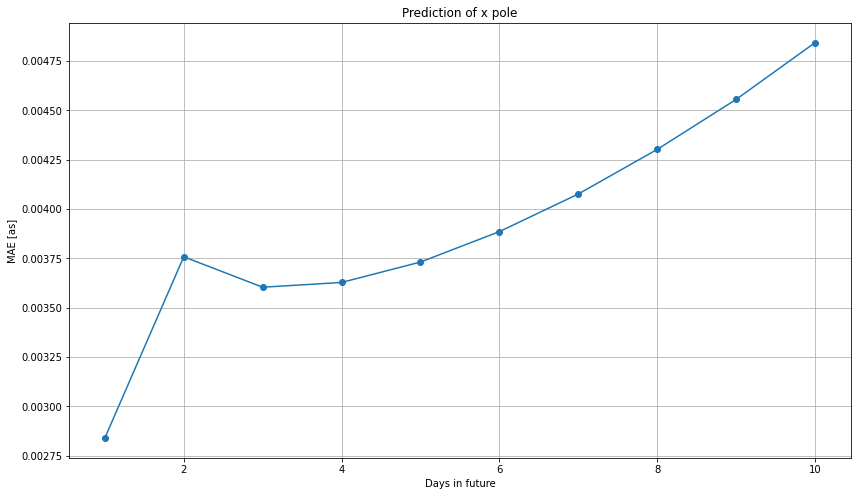

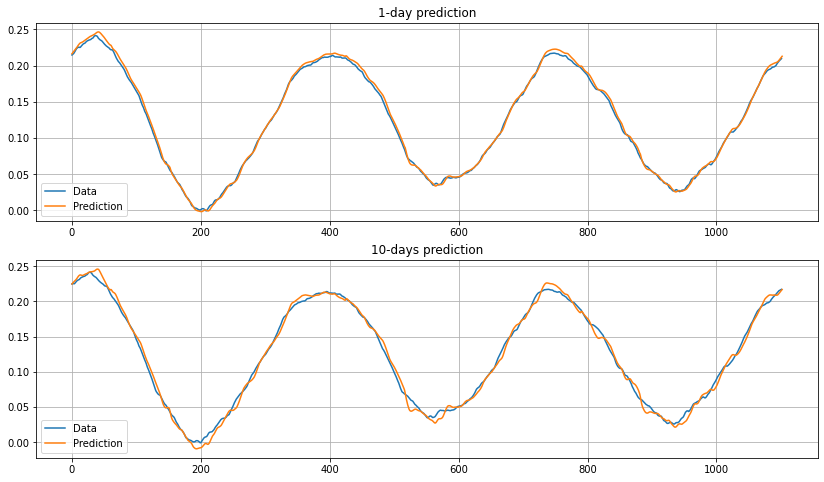

In [17]:
model = Sequential()
model.add(LSTM(45, input_shape=(input_width, train_df_x.shape[1])))
model.add(RepeatVector(label_width))
model.add(LSTM(10, return_sequences=True))
model.add(LSTM(7, return_sequences=True))
model.add(TimeDistributed(Dense(14)))
model.add(TimeDistributed(Dense(1)))
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss='mae')
model.summary()
#########################################################################

print('Input shape:', wide_window_x.example_x[0].shape)
print('Output shape:', model(wide_window_x.example_x[0]).shape)
#########################################################################

def compile_and_fit(model, window, patience=30):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min',restore_best_weights=True)
  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=opt,
                metrics=[tf.metrics.MeanAbsoluteError(),tf.metrics.MeanAbsolutePercentageError()])
  history = model.fit(window.train_x, epochs=MAX_EPOCHS,
                      validation_data=window.val_x,
                      callbacks=[early_stopping])
  return history
########################################################################

history = compile_and_fit(model, wide_window_x)
########################################################################

IPython.display.clear_output()
########################################################################

val_performance={}
performance={}
########################################################################

val_performance['(x,t) --> x'] = model.evaluate(wide_window_x.val_x)

performance['(x,t) --> x'] = model.evaluate(wide_window_x.test_x)
########################################################################

y1=[]
for i in range(test_df_x.shape[0]-input_width-shift):
    y=test_df_x['x'][input_width+i+1:input_width+i+shift+1]*train_std_x['x']+train_mean_x['x']
    y1.append(y)
    #print(y.shape)

y_hat = model.predict(wide_window_x.test_x, verbose=0)*train_std_x['x']+train_mean_x['x']
y_hat = y_hat.reshape(y_hat.shape[0], y_hat.shape[1])

diff1=[]
for i in range(0,y_hat.shape[0]-1):
    diff = y_hat[i,:] - y1[i]
    diff1.append(np.abs(diff))

MAE_x = np.mean(diff1, axis=0)  
print(MAE_x)  
plt.figure(figsize=(14, 8))
plt.plot(range(1, 11), MAE_x, 'o-')
plt.xlabel('Days in future')
plt.ylabel('MAE [as]')
plt.title('Prediction of x pole')
plt.grid()

plt.figure(figsize=(14, 8))
plt.subplot(2, 1, 1)
u=np.array(y1)
plt.plot(u[:,0], label='Data')
plt.plot(y_hat[:,0], label='Prediction')
plt.grid()
plt.legend()
plt.title('1-day prediction')
plt.subplot(2, 1, 2)
plt.plot(u[:,9], label='Data')
plt.plot(y_hat[:, 9], label='Prediction')
plt.grid()
plt.legend()
plt.title('10-days prediction')

# Test2: prediction of y based on time and y itself

23/23 [==============================] - 0s 13ms/step - loss: 0.0018 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 17.4911
[0.00395422 0.00315993 0.00385338 0.00434901 0.00455815 0.00476281
 0.00500962 0.0053005  0.0056211  0.00596409]


Text(0.5, 1.0, '10-days prediction')

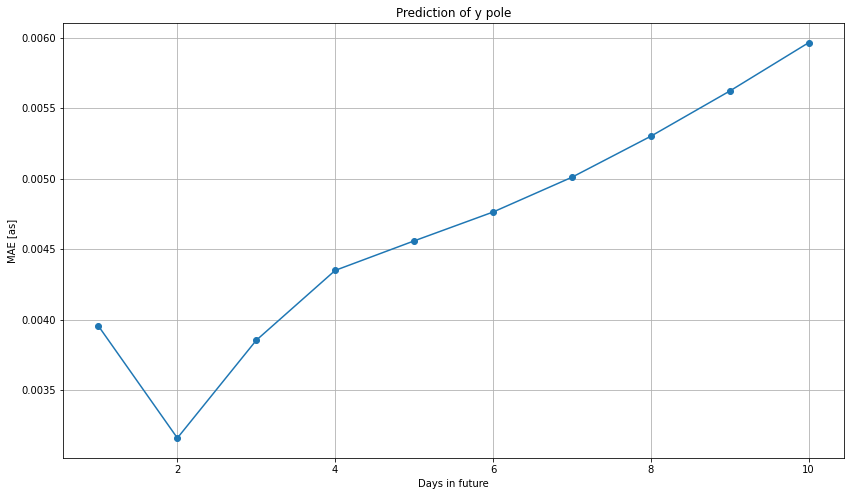

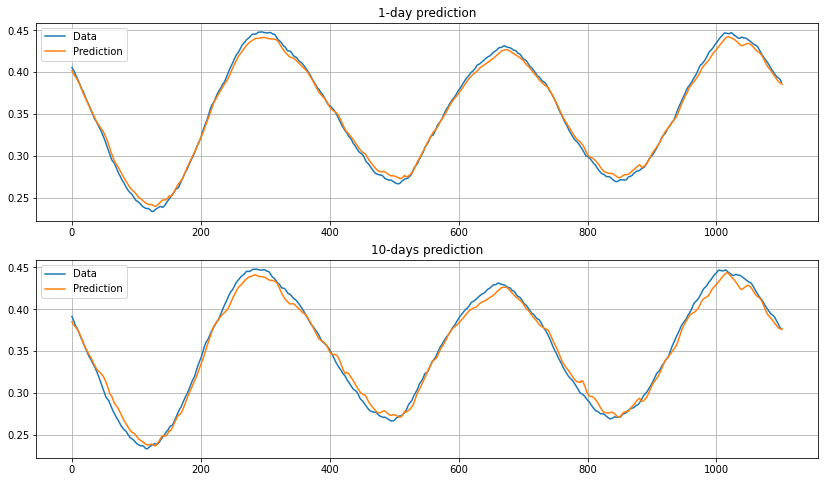

In [18]:
model = Sequential()
model.add(LSTM(45, input_shape=(input_width, train_df_y.shape[1])))
model.add(RepeatVector(label_width))
model.add(LSTM(10, return_sequences=True))
model.add(LSTM(7, return_sequences=True))
model.add(TimeDistributed(Dense(14)))
model.add(TimeDistributed(Dense(1)))
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss='mae')
model.summary()
#########################################################################

print('Input shape:', wide_window_y.example_y[0].shape)
print('Output shape:', model(wide_window_y.example_y[0]).shape)
#########################################################################

def compile_and_fit(model, window, patience=30):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min',restore_best_weights=True)
  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=opt,
                metrics=[tf.metrics.MeanAbsoluteError(),tf.metrics.MeanAbsolutePercentageError()])
  history = model.fit(window.train_y, epochs=MAX_EPOCHS,
                      validation_data=window.val_y,
                      callbacks=[early_stopping])
  return history
########################################################################

history = compile_and_fit(model, wide_window_y)
########################################################################

IPython.display.clear_output()
########################################################################

val_performance['(y,t) --> y'] = model.evaluate(wide_window_y.val_y)

performance['(y,t) --> y'] = model.evaluate(wide_window_y.test_y)
########################################################################

y1=[]
for i in range(test_df_y.shape[0]-input_width-shift):
    y=test_df_y['y'][input_width+i+1:input_width+i+shift+1]*train_std_y['y']+train_mean_y['y']
    y1.append(y)
    #print(y.shape)

y_hat = model.predict(wide_window_y.test_y, verbose=0)*train_std_y['y']+train_mean_y['y']
y_hat = y_hat.reshape(y_hat.shape[0], y_hat.shape[1])

diff1=[]
for i in range(0,y_hat.shape[0]-1):
    diff = y_hat[i,:] - y1[i]
    diff1.append(np.abs(diff))

MAE_y = np.mean(diff1, axis=0)  
print(MAE_y)   
plt.figure(figsize=(14, 8))
plt.plot(range(1, 11), MAE_y, 'o-')
plt.xlabel('Days in future')
plt.ylabel('MAE [as]')
plt.title('Prediction of y pole')
plt.grid()

plt.figure(figsize=(14, 8))
plt.subplot(2, 1, 1)
u=np.array(y1)
plt.plot(u[:,0], label='Data')
plt.plot(y_hat[:,0], label='Prediction')
plt.grid()
plt.legend()
plt.title('1-day prediction')
plt.subplot(2, 1, 2)
plt.plot(u[:,9], label='Data')
plt.plot(y_hat[:, 9], label='Prediction')
plt.grid()
plt.legend()
plt.title('10-days prediction')

# Test3: prediction of x based on time, x and y

23/23 [==============================] - 0s 13ms/step - loss: 7.2664e-04 - mean_absolute_error: 0.0213 - mean_absolute_percentage_error: 36.7411
[0.00287591 0.00255534 0.00238968 0.00249901 0.00267499 0.0029352
 0.00326425 0.00364957 0.00407628 0.00456552]


Text(0.5, 1.0, '10-days prediction')

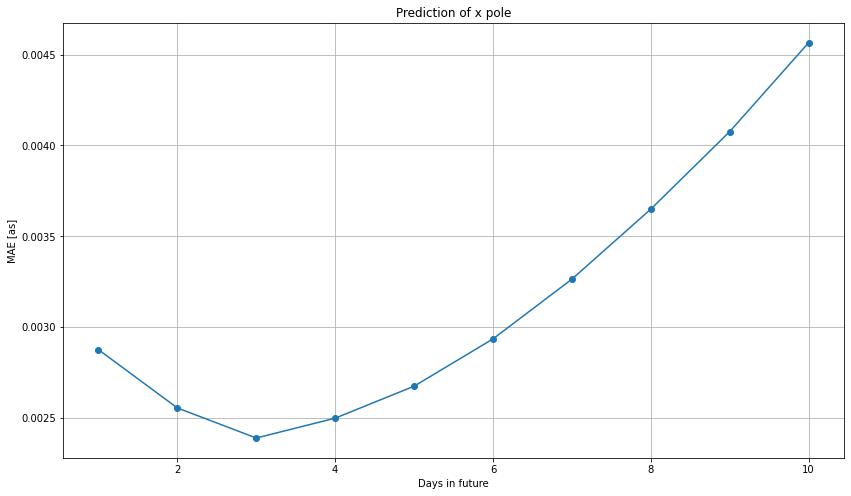

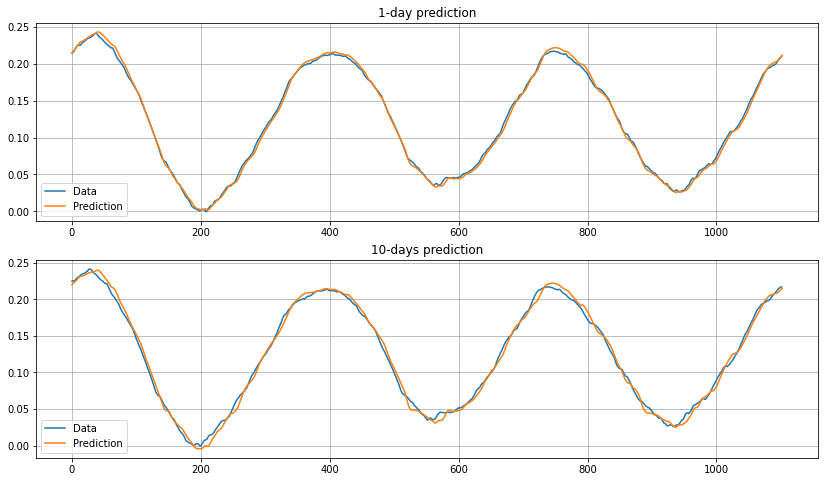

In [19]:
model = Sequential()
model.add(LSTM(45, input_shape=(input_width, train_df_xy.shape[1])))
model.add(RepeatVector(label_width))
model.add(LSTM(10, return_sequences=True))
model.add(LSTM(7, return_sequences=True))
model.add(TimeDistributed(Dense(14)))
model.add(TimeDistributed(Dense(1)))
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss='mae')
model.summary()
#########################################################################

print('Input shape:', wide_window_xy1.example_xy[0].shape)
print('Output shape:', model(wide_window_xy1.example_xy[0]).shape)
#########################################################################

def compile_and_fit(model, window, patience=30):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min',restore_best_weights=True)
  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=opt,
                metrics=[tf.metrics.MeanAbsoluteError(),tf.metrics.MeanAbsolutePercentageError()])
  history = model.fit(window.train_xy, epochs=MAX_EPOCHS,
                      validation_data=window.val_xy,
                      callbacks=[early_stopping])
  return history
########################################################################

history = compile_and_fit(model, wide_window_xy1)
########################################################################

IPython.display.clear_output()
########################################################################

val_performance['(x,y,t) --> x'] = model.evaluate(wide_window_xy1.val_xy)

performance['(x,y,t) --> x'] = model.evaluate(wide_window_xy1.test_xy)
########################################################################

y1=[]
for i in range(test_df_xy.shape[0]-input_width-shift):
    y=test_df_xy['x'][input_width+i+1:input_width+i+shift+1]*train_std_xy['x']+train_mean_xy['x']
    y1.append(y)
    #print(y.shape)

y_hat = model.predict(wide_window_xy1.test_xy, verbose=0)*train_std_xy['x']+train_mean_xy['x']
y_hat = y_hat.reshape(y_hat.shape[0], y_hat.shape[1])

diff1=[]
for i in range(0,y_hat.shape[0]-1):
    diff = y_hat[i,:] - y1[i]
    diff1.append(np.abs(diff))

MAE_xy1 = np.mean(diff1, axis=0)  
print(MAE_xy1)   
plt.figure(figsize=(14, 8))
plt.plot(range(1, 11), MAE_xy1, 'o-')
plt.xlabel('Days in future')
plt.ylabel('MAE [as]')
plt.title('Prediction of x pole')
plt.grid()

plt.figure(figsize=(14, 8))
plt.subplot(2, 1, 1)
u=np.array(y1)
plt.plot(u[:,0], label='Data')
plt.plot(y_hat[:,0], label='Prediction')
plt.grid()
plt.legend()
plt.title('1-day prediction')
plt.subplot(2, 1, 2)
plt.plot(u[:,9], label='Data')
plt.plot(y_hat[:, 9], label='Prediction')
plt.grid()
plt.legend()
plt.title('10-days prediction')


# Test4: prediction of y based on time, x and y

23/23 [==============================] - 0s 14ms/step - loss: 0.0013 - mean_absolute_error: 0.0303 - mean_absolute_percentage_error: 19.3659
[0.00357296 0.0024976  0.00190767 0.00260038 0.00357133 0.00430921
 0.00477558 0.0050345  0.00517059 0.00530737]


Text(0.5, 1.0, '10-days prediction')

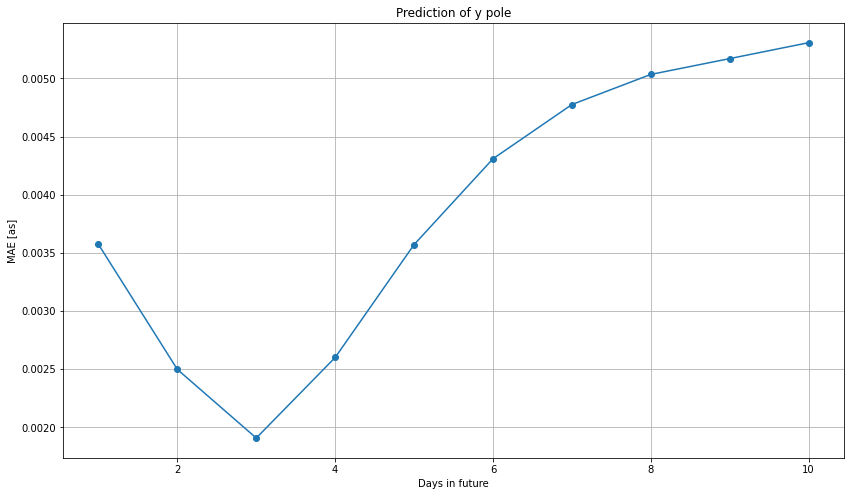

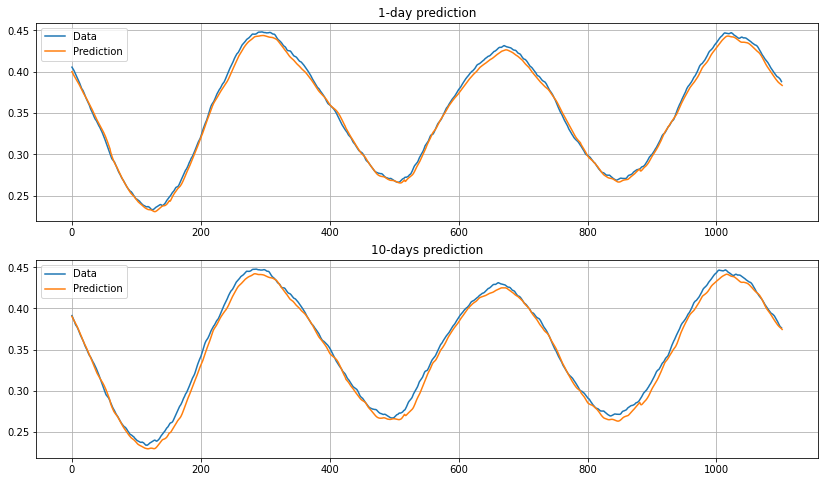

In [20]:
model = Sequential()
model.add(LSTM(45, input_shape=(input_width, train_df_xy.shape[1])))
model.add(RepeatVector(label_width))
model.add(LSTM(10, return_sequences=True))
model.add(LSTM(7, return_sequences=True))
model.add(TimeDistributed(Dense(14)))
model.add(TimeDistributed(Dense(1)))
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss='mae')
model.summary()
#########################################################################

print('Input shape:', wide_window_xy2.example_xy[0].shape)
print('Output shape:', model(wide_window_xy2.example_xy[0]).shape)
#########################################################################

def compile_and_fit(model, window, patience=30):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min',restore_best_weights=True)
  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=opt,
                metrics=[tf.metrics.MeanAbsoluteError(),tf.metrics.MeanAbsolutePercentageError()])
  history = model.fit(window.train_xy, epochs=MAX_EPOCHS,
                      validation_data=window.val_xy,
                      callbacks=[early_stopping])
  return history
########################################################################

history = compile_and_fit(model, wide_window_xy2)
########################################################################

IPython.display.clear_output()
########################################################################

val_performance['(x,y,t) --> y'] = model.evaluate(wide_window_xy2.val_xy)

performance['(x,y,t) --> y'] = model.evaluate(wide_window_xy2.test_xy)
########################################################################

y1=[]
for i in range(test_df_xy.shape[0]-input_width-shift):
    y=test_df_xy['y'][input_width+i+1:input_width+i+shift+1]*train_std_xy['y']+train_mean_xy['y']
    y1.append(y)
    #print(y.shape)

y_hat = model.predict(wide_window_xy1.test_xy, verbose=0)*train_std_xy['y']+train_mean_xy['y']
y_hat = y_hat.reshape(y_hat.shape[0], y_hat.shape[1])

diff1=[]
for i in range(0,y_hat.shape[0]-1):
    diff = y_hat[i,:] - y1[i]
    diff1.append(np.abs(diff))

MAE_xy2 = np.mean(diff1, axis=0)  
print(MAE_xy2)   
plt.figure(figsize=(14, 8))
plt.plot(range(1, 11), MAE_xy2, 'o-')
plt.xlabel('Days in future')
plt.ylabel('MAE [as]')
plt.title('Prediction of y pole')
plt.grid()

plt.figure(figsize=(14, 8))
plt.subplot(2, 1, 1)
u=np.array(y1)
plt.plot(u[:,0], label='Data')
plt.plot(y_hat[:,0], label='Prediction')
plt.grid()
plt.legend()
plt.title('1-day prediction')
plt.subplot(2, 1, 2)
plt.plot(u[:,9], label='Data')
plt.plot(y_hat[:, 9], label='Prediction')
plt.grid()
plt.legend()
plt.title('10-days prediction')


# Test5: prediction of (x,y) based on time, and (x,y)

23/23 [==============================] - 0s 14ms/step - loss: 0.0033 - mean_absolute_error: 0.0461 - mean_absolute_percentage_error: 40.1308
[0.00557501 0.00494965 0.00449409 0.00482077 0.00545696 0.00604773
 0.00654262 0.00696702 0.00736963 0.00778654]


Text(0.5, 1.0, '10-days prediction')

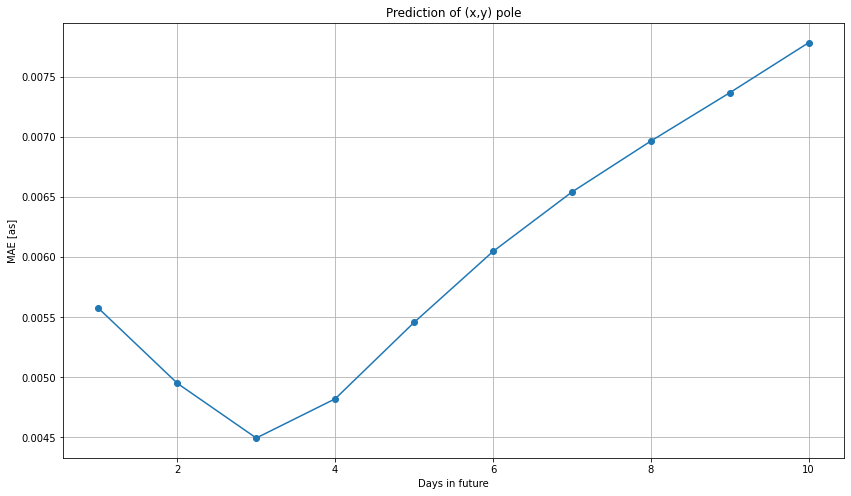

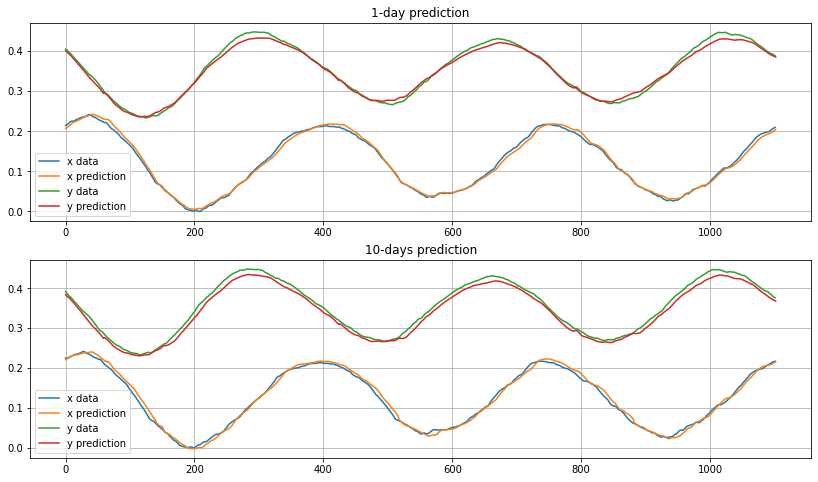

In [21]:
model = Sequential()
model.add(LSTM(45, input_shape=(input_width, train_df_xy.shape[1])))
model.add(RepeatVector(label_width))
model.add(LSTM(10, return_sequences=True))
model.add(LSTM(7, return_sequences=True))
model.add(TimeDistributed(Dense(14)))
model.add(TimeDistributed(Dense(2)))
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss='mae')
model.summary()
#########################################################################

print('Input shape:', wide_window_xy3.example_xy[0].shape)
print('Output shape:', model(wide_window_xy3.example_xy[0]).shape)
#########################################################################

def compile_and_fit(model, window, patience=30):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min',restore_best_weights=True)
  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=opt,
                metrics=[tf.metrics.MeanAbsoluteError(),tf.metrics.MeanAbsolutePercentageError()])
  history = model.fit(window.train_xy, epochs=MAX_EPOCHS,
                      validation_data=window.val_xy,
                      callbacks=[early_stopping])
  return history
########################################################################

history = compile_and_fit(model, wide_window_xy3)
########################################################################

IPython.display.clear_output()
########################################################################

val_performance['(x,y,t) --> (x,y)'] = model.evaluate(wide_window_xy3.val_xy)

performance['(x,y,t) --> (x,y)'] = model.evaluate(wide_window_xy3.test_xy)
########################################################################

y1=[]
for i in range(test_df_xy.shape[0]-input_width-shift):
    y=test_df_xy[['x','y']][input_width+i+1:input_width+i+shift+1]
    y1.append(y)
    #print(y.shape)

    
y1=np.array(y1)
y_hat = model.predict(wide_window_xy3.test_xy, verbose=0)
y_hat = y_hat.reshape(y_hat.shape[0], y_hat.shape[1],y_hat.shape[2])
y_hat[:,:,0]=y_hat[:,:,0]*train_std_xy['x']+train_mean_xy['x']
y_hat[:,:,1]=y_hat[:,:,1]*train_std_xy['y']+train_mean_xy['y']

y1[:,:,0]=y1[:,:,0]*train_std_xy['x']+train_mean_xy['x']
y1[:,:,1]=y1[:,:,1]*train_std_xy['y']+train_mean_xy['y']

diff1=[]
for i in range(0,y_hat.shape[0]-1):
    diff = y_hat[i,:] - y1[i,:]
    diff1.append(np.abs(diff))

MAE_xy3 = np.mean(diff1,axis=(0,2))  
print(MAE_xy3)   
plt.figure(figsize=(14, 8))
plt.plot(range(1, 11), MAE_xy3, 'o-')
plt.xlabel('Days in future')
plt.ylabel('MAE [as]')
plt.title('Prediction of (x,y) pole')
plt.grid()

plt.figure(figsize=(14, 8))
plt.subplot(2, 1, 1)
u=np.array(y1)
plt.plot(u[:,0,0], label='x data')
plt.plot(y_hat[:,0,0], label='x prediction')
plt.plot(u[:,0,1], label='y data')
plt.plot(y_hat[:,0,1], label='y prediction')
plt.grid()
plt.legend()
plt.title('1-day prediction')
plt.subplot(2, 1, 2)
plt.plot(u[:,9,0], label='x data')
plt.plot(y_hat[:, 9,0], label='x prediction')
plt.plot(u[:,9,1], label='y data')
plt.plot(y_hat[:, 9,1], label='y prediction')
plt.grid()
plt.legend()
plt.title('10-days prediction')

# Compare performances (after scaling back to the original scale)

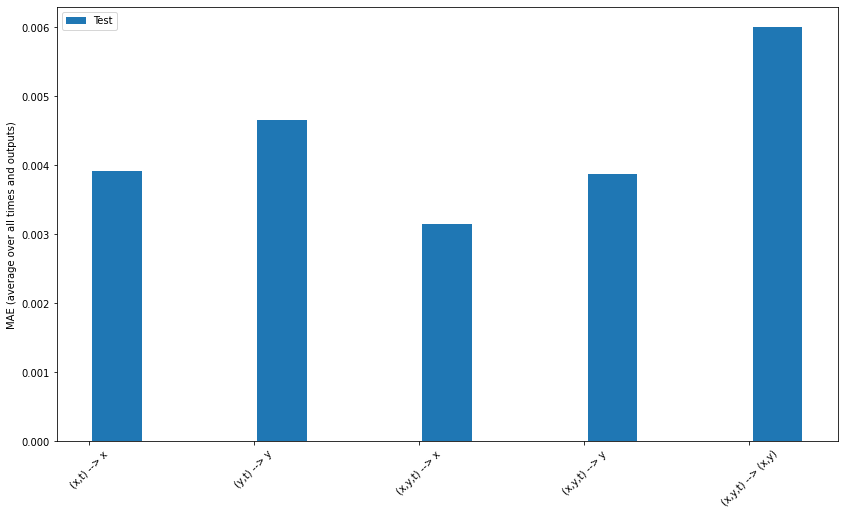

In [31]:
x = np.arange(len(performance))
width = 0.3




test_mae=np.zeros((5))
test_mae[0]=np.mean(MAE_x)
test_mae[1]=np.mean(MAE_y)
test_mae[2]=np.mean(MAE_xy1)
test_mae[3]=np.mean(MAE_xy2)
test_mae[4]=np.mean(MAE_xy3)

#plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [32]:
i=0
for name, value in performance.items():
  print(f'{name:8s}: {test_mae[i]:0.4f}')
  i+=1

(x,t) --> x: 0.0039
(y,t) --> y: 0.0047
(x,y,t) --> x: 0.0031
(x,y,t) --> y: 0.0039
(x,y,t) --> (x,y): 0.0060
